In [1]:
import pandas as pd
import json

In [18]:
# Import Python Libraries
import sys
import altair as alt
import pandas as pd
import numpy as np
import calendar
# print (pd.__version__)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
warnings.filterwarnings('ignore')
alt.data_transformers.disable_max_rows()
%matplotlib inline

In [15]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charleestefanski/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Toy Data

In [4]:
!ls data/toy_data

dev_queries     qrel            val_collection
full_collection triplets        val_queries


In [26]:
columns = ["pid", "passage"]
toy_full_collec = pd.read_table("data/toy_data/full_collection/raw.tsv",sep='\t', header=None, index_col = 0, names=columns)
toy_full_collec.head()

,passage
pid,
0,The presence of communication amid scientific ...
1,The Manhattan Project and its atomic bomb help...
2,Essay on The Manhattan Project - The Manhattan...
3,The Manhattan Project was the name for a proje...
4,versions of each volume as well as complementa...


In [25]:
toy_full_collec.shape

(89, 1)

In [24]:
columns = ["qid", "query"]
toy_queries = pd.read_table("data/toy_data/dev_queries/raw.tsv",sep='\t', header=None, names=columns)
toy_queries.head()

,qid,query
0,786786,Androgen receptor define
1,1048642,treating tension headaches without medication
2,1048876,what is paranoid sc


In [27]:
toy_queries.shape

(3, 2)

In [29]:
columns = ['query', 'positive_passage', 'negative_passage']
toy_triplets = pd.read_table("data/toy_data/triplets/raw.tsv",sep='\t', header=None, names=columns)
pd.set_option('display.max_colwidth', None) 
toy_triplets.head()

,query,positive_passage,negative_passage
0,is a little caffeine ok during pregnancy,"We donât know a lot about the effects of caffeine during pregnancy on you and your baby. So itâs best to limit the amount you get each day. If youâre pregnant, limit caffeine to 200 milligrams each day. This is about the amount in 1Â½ 8-ounce cups of coffee or one 12-ounce cup of coffee.","It is generally safe for pregnant women to eat chocolate because studies have shown to prove certain benefits of eating chocolate during pregnancy. However, pregnant women should ensure their caffeine intake is below 200 mg per day."
1,what fruit is native to australia,"Passiflora herbertiana. A rare passion fruit native to Australia. Fruits are green-skinned, white fleshed, with an unknown edible rating. Some sources list the fruit as edible, sweet and tasty, while others list the fruits as being bitter and inedible.assiflora herbertiana. A rare passion fruit native to Australia. Fruits are green-skinned, white fleshed, with an unknown edible rating. Some sources list the fruit as edible, sweet and tasty, while others list the fruits as being bitter and inedible.","The kola nut is the fruit of the kola tree, a genus (Cola) of trees that are native to the tropical rainforests of Africa."
2,how large is the canadian military,"The Canadian Armed Forces. 1 The first large-scale Canadian peacekeeping mission started in Egypt on November 24, 1956. 2 There are approximately 65,000 Regular Force and 25,000 reservist members in the Canadian military. 3 In Canada, August 9 is designated as National Peacekeepersâ Day.","The Canadian Physician Health Institute (CPHI) is a national program created in 2012 as a collaboration between the Canadian Medical Association (CMA), the Canadian Medical Foundation (CMF) and the Provincial and Territorial Medical Associations (PTMAs)."
3,types of fruit trees,"Cherry. Cherry trees are found throughout the world. There are 40 or more varieties, ranging from bing cherry to black cherry. Along with the fruit, cherry trees produce light and delicate pinkish-white blossoms that are highly fragrant.omments. Submit. Planting fruit trees on your property not only provides you with a steady supply of organic fruit, it also allows you to beautify your yard and give oxygen back to the environment.","The kola nut is the fruit of the kola tree, a genus (Cola) of trees that are native to the tropical rainforests of Africa."
4,how many calories a day are lost breastfeeding,"Not only is breastfeeding better for the baby, however, research also says itâs better for the mother. Breastfeeding burns an average of 500 calories a day, with the typical range from 200 to 600 calories burned a day. Itâs estimated that the production of 1 oz. of breast milk burns 20 calories. The amount of calories burned depending on how much the baby eats. Breastfeeding twins burn twice as much as feeding only one baby. With twins their mom burns 1000 calories a day. Burning an extra 500 calories a day will result in one pound of weekly weight loss.","However, you still need some niacin each day; men need about 16 mg per day and women need 14 mg per day unless they are pregnant or nursing (pregnant and breastfeeding women have higher niacin requirements)."


In [19]:
toy_triplets.shape

(100, 3)

In [22]:
with open('data/toy_data/qrel/qrel.json') as json_file:
    qrel_dict = json.load(json_file)

In [23]:
qrel_dict

{'2': {'69': 1},
 '1048642': {'45': 1},
 '524447': {'12': 1},
 '524332': {'34': 1},
 '786674': {'38': 1, '99': 1},
 '1048876': {'1': 1},
 '1048917': {'12': 1, '50': 1},
 '786786': {'1': 1},
 '524699': {'78': 1}}

In [48]:
toy_queries.query('qid == 1048642')['query'][1]

'treating tension headaches without medication'

In [51]:
toy_full_collec.query('pid == 45')['passage'][45]

'About us. Medical Tours Costa Rica has helped thousands of patients and are the innovators in medical travel to Costa Rica. Brad and Bill Cook are visionaries that saw the writing on the wall while running the International insurance office for Costa Ricaâs busiest and most respected hospital The Clinica Biblica.'

## MSMARCO Data

In [52]:
columns = ["pid", "passage"]
passages = pd.read_table("data/msmarco/full_collection/raw.tsv",sep='\t', header=None, names=columns)
passages.head()

,pid,passage
0,0,The presence of communication amid scientific ...
1,1,The Manhattan Project and its atomic bomb help...
2,2,Essay on The Manhattan Project - The Manhattan...
3,3,The Manhattan Project was the name for a proje...
4,4,versions of each volume as well as complementa...


In [53]:
passages.shape

(8841823, 2)

In [54]:
columns = ["qid", "query"]
queries = pd.read_table("data/msmarco/dev_queries/raw.tsv",sep='\t', header=None, names=columns)
queries.head()

,qid,query
0,1048585,what is paula deen's brother
1,2,Androgen receptor define
2,524332,treating tension headaches without medication
3,1048642,what is paranoid sc
4,524447,treatment of varicose veins in legs


In [55]:
queries.shape

(6980, 2)

In [56]:
train_queries = pd.read_csv("data/msmarco/train_queries/queries/raw.tsv",sep='\t', header=None, names=columns)
train_queries.head()

,qid,query
0,121352,define extreme
1,634306,what does chattel mean on credit history
2,920825,what was the great leap forward brainly
3,510633,tattoo fixers how much does it cost
4,737889,what is decentralization process.


In [57]:
train_queries.shape

(808731, 2)

### Example query passage matches

In [84]:
q = train_queries.query('qid == 287144')['query'].iloc[0]
p = passages.query('pid == 85742')['passage'].iloc[0]
print("query: ", q)
print("passage: ", p)

query:  how many kilojoules per day teenager
passage:  How many kilojoules should an 18 year old girl have each day? You should be safe with around 8000-9000 kilojoules per day but it is highly relative to you personally and factors such as height, activity, age, gender and weight are inclus … ive in calculating how many kilojoules you should have.


In [86]:
q = train_queries.query('qid == 287145')['query'].iloc[0]
p = passages.query('pid == 6849904')['passage'].iloc[0]
print("query: ", q)
print("passage: ", p)

query:  how many kiloliters are in a liter
passage:  Chemistry question: How many kiloliters is in a liter? 1 liter = 0.001 kiloliters and 1 kiloliter = 1000 liter. 55L =0.055 kiloliters 0 12 months ago Metric units are easy, kilo means 1000, and Liter is a base unit for volume.


In [87]:
q = train_queries.query('qid == 287140')['query'].iloc[0]
p = passages.query('pid == 5332427')['passage'].iloc[0]
print("query: ", q)
print("passage: ", p)

query:  how many kilograms per pound?
passage:  Confidence votes 7.7K. 1 pound is 0.453592 kilograms. On earth, one kilogram of mass weighs about 2.205 pounds (rounded), and 0.4536 kilogram (rounded) weighs one pound. Karl Creighton.


In [88]:
q = train_queries.query('qid == 287141')['query'].iloc[0]
p = passages.query('pid == 4531496')['passage'].iloc[0]
print("query: ", q)
print("passage: ", p)

query:  how many kilohertz in a megahertz
passage:  One megahertz (abbreviated: MHz) is equal to 1,000 kilohertz, or 1,000,000 hertz. It can also be described as one million cycles per second. Megahertz is used to measure wave frequencies, as well as the speed of microprocessors. Radio waves, which are used for both radio and TV broadcasts, are typically measured in megahertz.


In [89]:
q = train_queries.query('qid == 1057505')['query'].iloc[0]
p = passages.query('pid == 3958822')['passage'].iloc[0]
p2 = passages.query('pid == 3958823')['passage'].iloc[0]
print("query: ", q)
print("passages: ", p)
print(p2)

query:  who were the maccabees
passages:  For other uses, see Maccabees (disambiguation). The Maccabees, also spelled Machabees (Hebrew: מכבים or מקבים‎‎, Maqabim; Latin: Machabaei or Maccabaei; Greek: μακκαβαῖοι, Makkabaioi), were the leaders of a Jewish rebel army that took control of Judea, which at the time had been a province of the Seleucid Empire.
The descendants of Mattathias. The Maccabees, also spelled Machabees (Hebrew: מכבים or מקבים‎‎, Maqabim; Latin: Machabaei or Maccabaei; Greek: μακκαβαῖοι, Makkabaioi), were the leaders of a Jewish rebel army that took control of Judea, which at the time had been a province of the Seleucid Empire.


### Closer look at passages

In [97]:
words_corp = passages.sample(n=1000000)['passage'].apply(lambda wrd: len(wrd.split()))

In [110]:
words_corp.max()

280

In [99]:
words_corp.min()

1

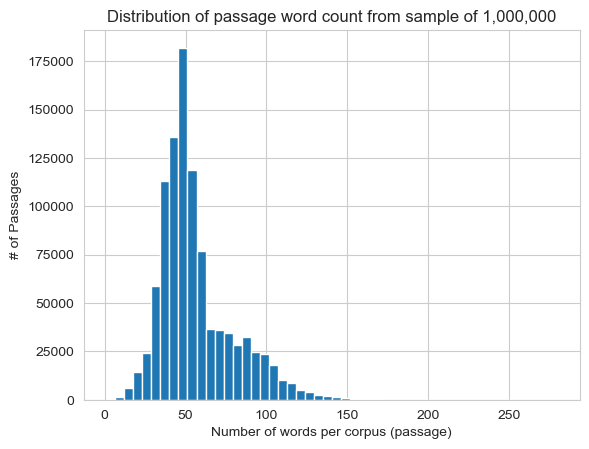

In [113]:
plt.hist(words_corp, bins=50)
plt.xlabel('Number of words per corpus (passage)')
plt.ylabel('# of Passages')
plt.title('Distribution of passage word count from sample of 1,000,000')
plt.grid(b=True)

((array([-4.82696512, -4.64718223, -4.54998406, ...,  4.54998406,
          4.64718223,  4.82696512]),
  array([  1,   1,   1, ..., 235, 246, 280])),
 (21.56517501080682, 56.24175199999999, 0.9513056077695436))

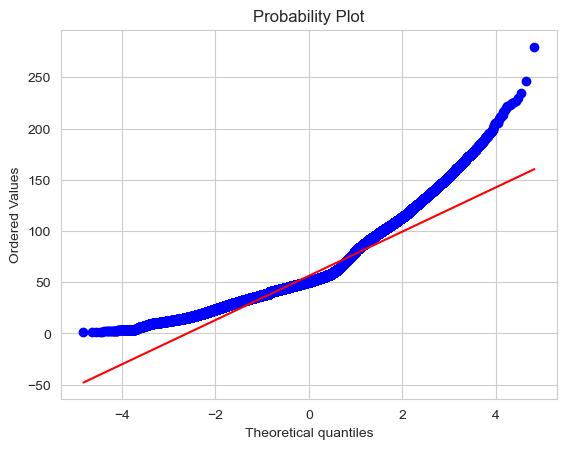

In [112]:
# Check the distribution normality
stats.probplot(words_corp, plot=plt)

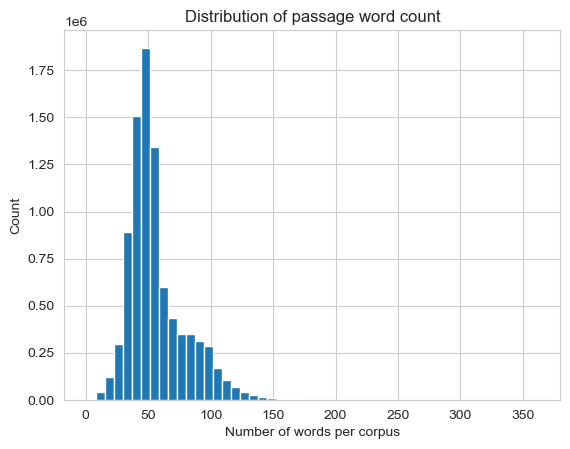

In [115]:
plt.hist(passages['passage'].apply(lambda wrd: len(wrd.split())), bins=50)
plt.xlabel('Number of words per corpus')
plt.ylabel('Count')
plt.title('Distribution of passage word count')
plt.grid(b=True)

In [116]:
uniq_words = passages[:1000000]['passage'].apply(lambda wrd: len(set(str(wrd).split())))
uniq_words

0         38
1         27
2         32
3         39
4         30
          ..
999995    51
999996    40
999997    44
999998    58
999999    54
Name: passage, Length: 1000000, dtype: int64

Text(0.5, 1.0, 'Unique words per corpus (passage)')

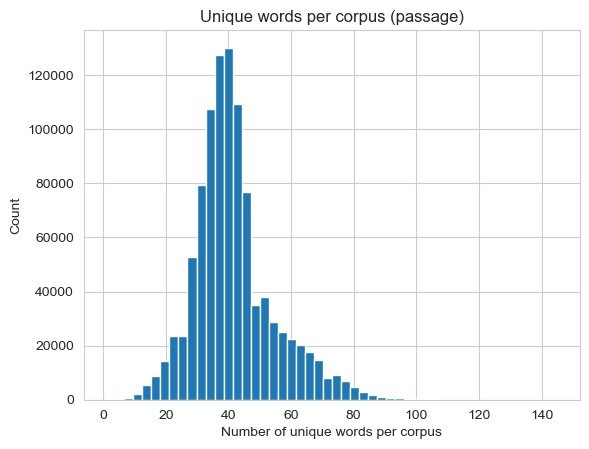

In [117]:
plt.hist(uniq_words, bins=50)
plt.xlabel('Number of unique words per corpus')
plt.ylabel('Count')
plt.title('Unique words per corpus (passage)')

((array([-4.82696512, -4.64718223, -4.54998406, ...,  4.54998406,
          4.64718223,  4.82696512]),
  array([  1,   1,   1, ..., 134, 144, 145])),
 (12.540956571422742, 41.693698, 0.9738140890186551))

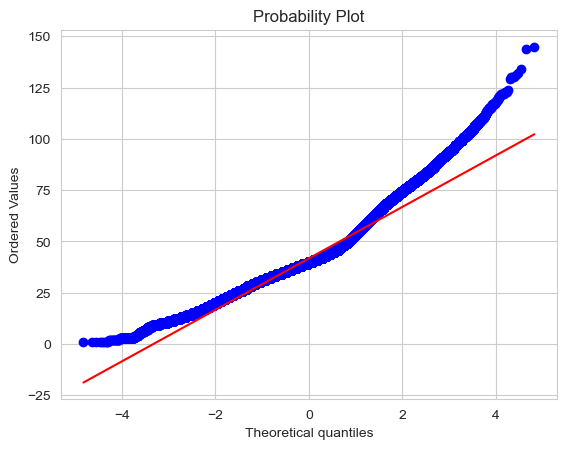

In [118]:
# Check the distribution normality
stats.probplot(uniq_words, plot=plt)

In [119]:
char_corp = passages[:1000000]['passage'].apply(len)
char_corp

0         325
1         175
2         250
3         292
4         309
         ... 
999995    464
999996    350
999997    346
999998    467
999999    408
Name: passage, Length: 1000000, dtype: int64

Text(0, 0.5, 'Count')

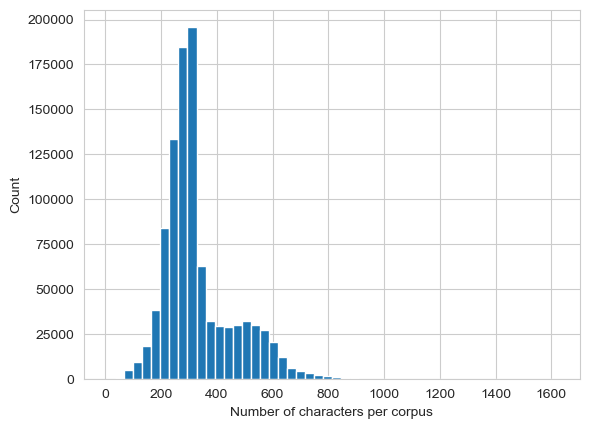

In [120]:
plt.hist(char_corp, bins=50)
plt.xlabel('Number of characters per corpus')
plt.ylabel('Count')

((array([-4.82696512, -4.64718223, -4.54998406, ...,  4.54998406,
          4.64718223,  4.82696512]),
  array([   4,    5,    5, ..., 1266, 1397, 1621])),
 (120.85874343421568, 332.96433699999994, 0.9447820281094406))

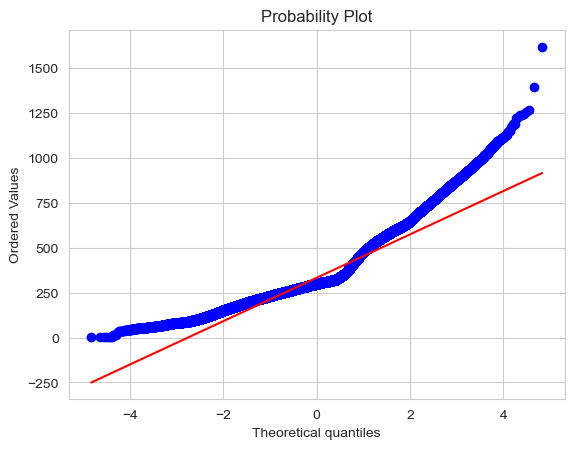

In [121]:
# Check the distribution normality
stats.probplot(char_corp, plot=plt)

In [122]:
counts = pd.DataFrame({'words_per_corpus':words_corp, 'unique_words_per_corpus':uniq_words, "characters_per_corpus":char_corp})

<AxesSubplot:>

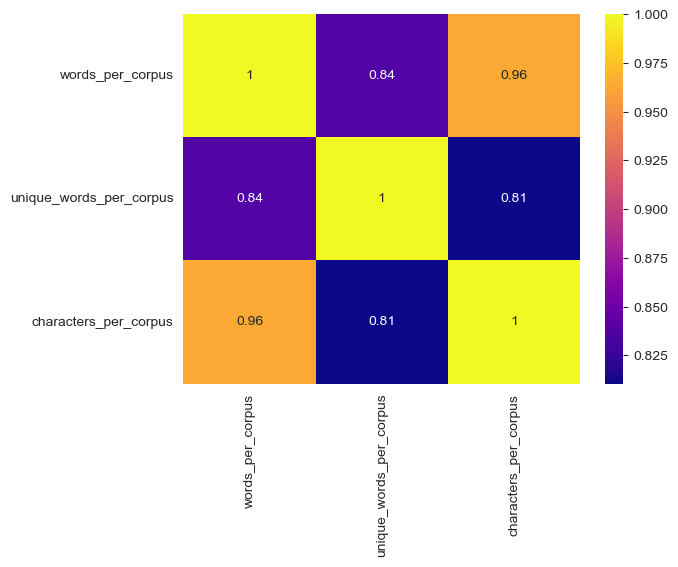

In [123]:
corr= counts.corr()
sns.heatmap(corr,annot=True, cmap= 'plasma')

<AxesSubplot:xlabel='characters_per_corpus', ylabel='words_per_corpus'>

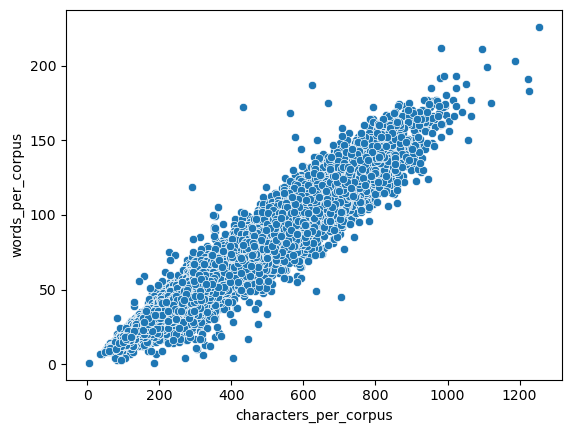

<AxesSubplot:xlabel='characters_per_corpus', ylabel='unique_words_per_corpus'>

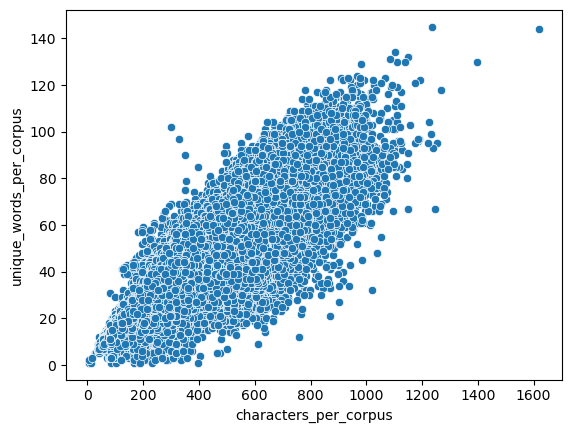

In [36]:
sns.scatterplot(x='characters_per_corpus', y='words_per_corpus', data = counts)

<AxesSubplot:xlabel='words_per_corpus', ylabel='unique_words_per_corpus'>

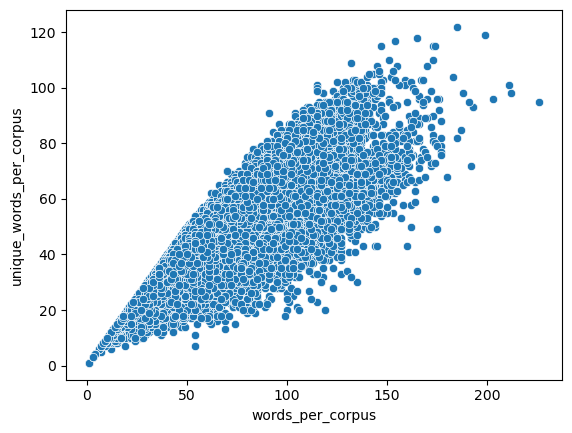

In [37]:
sns.scatterplot(x='characters_per_corpus', y='unique_words_per_corpus', data = counts)

In [ ]:
sns.scatterplot(x='words_per_corpus', y='unique_words_per_corpus', data = counts)

### Closer look at queries

In [3]:
columns = ["qid", "query"]
all_queries = pd.read_table("data/full_data/queries.train.tsv",sep='\t', header=None, names=columns)
all_queries.head()

,qid,query
0,121352,define extreme
1,634306,what does chattel mean on credit history
2,920825,what was the great leap forward brainly
3,510633,tattoo fixers how much does it cost
4,737889,what is decentralization process.


In [4]:
all_queries.shape

(808731, 2)

In [5]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1

    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
    x,y=zip(*top)
    plt.bar(x,y)

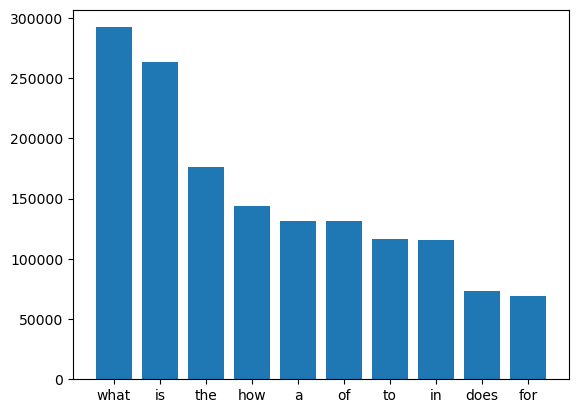

In [12]:
plot_top_stopwords_barchart(all_queries['query'])

In [16]:
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

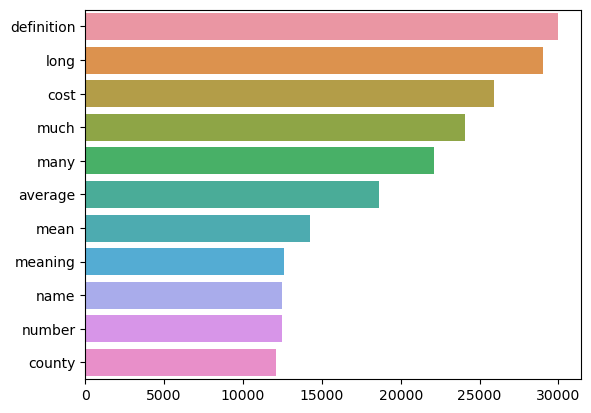

In [17]:
plot_top_non_stopwords_barchart(all_queries['query'])

In [19]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

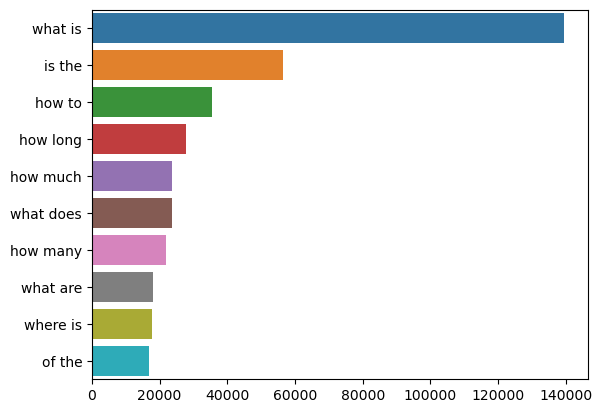

In [20]:
plot_top_ngrams_barchart(all_queries['query'])

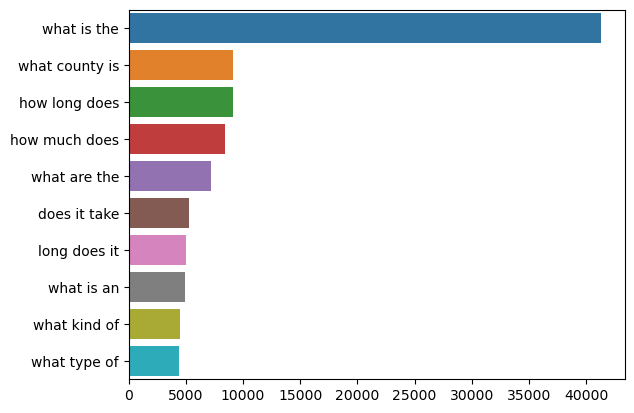

In [21]:
plot_top_ngrams_barchart(all_queries['query'], 3)

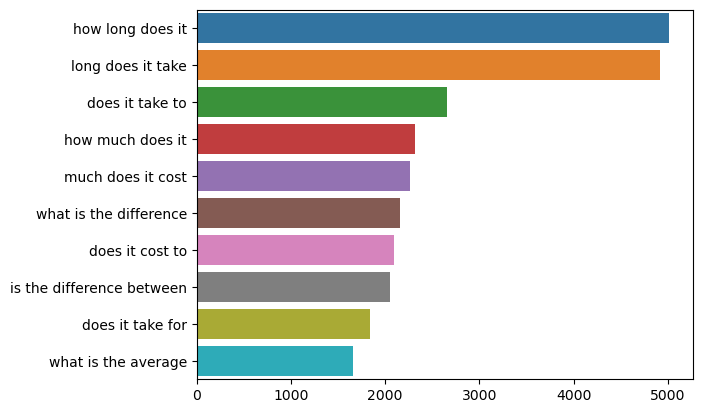

In [22]:
plot_top_ngrams_barchart(all_queries['query'], 4)